# Import

In [42]:
import torch 
from fastai.vision.all import * 
import cv2 as cv
import fastbook
from fastbook import *
from fastai.vision.widgets import *
import os

# Data

refer : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [48]:
# path=Path('./home/Dropbox/chest_xray/chest_xray') 
path = Path(os.path.expanduser(os.path.join('~', 'Dropbox/chest_xray/chest_xray')))

In [49]:
path.ls()

(#3) [Path('/home/csy/Dropbox/chest_xray/chest_xray/train'),Path('/home/csy/Dropbox/chest_xray/chest_xray/test'),Path('/home/csy/Dropbox/chest_xray/chest_xray/val')]

In [50]:
files=get_image_files(path)

In [51]:
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.2, item_tfms=Resize(224))      

In [52]:
dls.vocab

['NORMAL', 'PNEUMONIA']

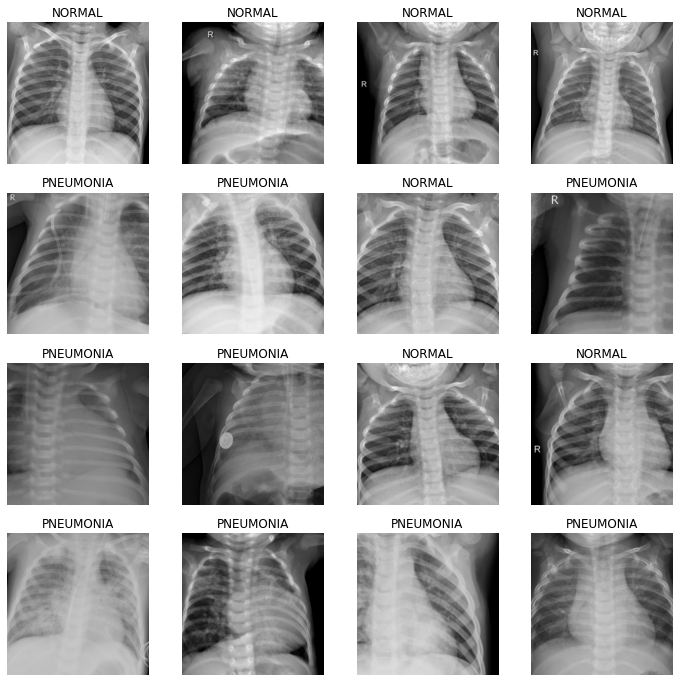

In [53]:
dls.show_batch(max_n=16)

In [54]:
learn=cnn_learner(dls,resnet34,metrics=error_rate)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
net1=learn.model[0]
net2=learn.model[1] 

In [56]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [57]:
net=torch.nn.Sequential(net1,net2)

In [58]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [ ]:
lrnr2.fine_tune(200) 

epoch,train_loss,valid_loss,accuracy,time
0,0.256840,0.114656,0.955594,08:44


epoch,train_loss,valid_loss,accuracy,time
0,0.116520,0.101848,0.963279,09:36
1,0.102428,0.094126,0.967549,08:12
2,0.093699,0.093717,0.967549,08:54
3,0.086143,0.088825,0.970111,09:29
4,0.081806,0.083427,0.972673,07:39
5,0.073343,0.083292,0.970965,08:30
6,0.067238,0.081730,0.971819,09:19
7,0.060490,0.080178,0.970965,07:47
8,0.057268,0.082641,0.971819,07:59
9,0.051426,0.083972,0.970965,09:19


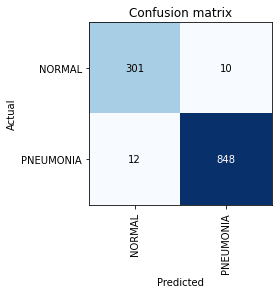

In [61]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

In [ ]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        normalprob, pneumoniaprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if normalprob>pneumoniaprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("normal(%s)" % normalprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("pneumonia(%s)" % pneumoniaprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
img = PILImage.create(get_image_files(path)[3014])
img

In [ ]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [ ]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

In [ ]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

설명

In [ ]:
test=camimg[1]-torch.min(camimg[1])

In [ ]:
A1=torch.exp(-0.045*test)

In [ ]:
A2=1-A1

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("X1 WEIGHT WITH THETA=0.04")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("X1 RES WEIGHT WITH THETA=0.04")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv.resize(X1,(224,224),interpolation=cv.INTER_LINEAR))
x1=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*0.7*Y1))*0.4

In [ ]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv.resize(X1,(224,224),interpolation=cv.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12*3

1st cam 결과 분리

In [ ]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("X1")
ax2.set_title("X1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
x1=x1.reshape(1,3,224,224)

In [ ]:
net1.to('cpu')
net2.to('cpu')

In [ ]:
ver2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(ver2[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x1.squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

$\theta$ 생각

In [ ]:
test1=ver2[0]-torch.min(ver2[0])

In [ ]:
A3=torch.exp(-0.04*test1)  

In [ ]:
A4=1-A3

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE2 WEIGHT WITH THETA=0.04")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE2 RES WEIGHT WITH THETA=0.04")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
#mode2_res
X3=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv.resize(X3,(224,224),interpolation=cv.INTER_LINEAR))
x3=x.squeeze().to('cpu')*Y1*Y3-torch.min(x.squeeze().to('cpu')*Y1*Y3)

In [ ]:
#mode1*x
X4=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y4=torch.Tensor(cv.resize(X4,(224,224),interpolation=cv.INTER_LINEAR))
x4=x.squeeze().to('cpu')*Y1*Y4

2nd 분리 결과

In [ ]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  
x1.squeeze().show(ax=ax2)  
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x4.squeeze().show(ax=ax1)  
x3.squeeze().show(ax=ax2)  
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
x3=x3.reshape(1,3,224,224)

In [ ]:
net1.to('cpu')
net2.to('cpu')

In [ ]:
ver22 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

cam

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x3.squeeze().show(ax=ax1)
ax1.imshow(ver22[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x3.squeeze().show(ax=ax2)
ax2.imshow(ver22[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(ver22[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
#

fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [ ]:
a2=net(x3).tolist()[0][0]
b2=net(x3).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

특정 그림

In [ ]:
img = PILImage.create(get_image_files(path)[3013])
img

철심

In [ ]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [ ]:
x=x.to('cpu')

In [ ]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

In [ ]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
test=camimg[0]-torch.min(camimg[0])

In [ ]:
test1=camimg[1]-torch.min(camimg[1])

In [ ]:
A1=torch.exp(-0.05*test)

In [ ]:
A2=1-A1

In [ ]:
A11=torch.exp(-0.05*test1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("X1 WEIGHT WITH THETA=0.05")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A11.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("X1 RES WEIGHT WITH THETA=0.05")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
#mode1_res*x
X1=np.array(A11.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv.resize(X1,(224,224),interpolation=cv.INTER_LINEAR))
#x1=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*0.7*Y1))*0.4
x1=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1))*0.18

In [ ]:
#mode1그림을 위한 mode1_res*x
X_1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y_1=torch.Tensor(cv.resize(X1,(224,224),interpolation=cv.INTER_LINEAR))
#x1=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*0.7*Y1))*0.4
x_1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)*0.05

In [ ]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv.resize(X_1,(224,224),interpolation=cv.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12*0.3

1st cam 결과

In [ ]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("X1")
ax2.set_title("X1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
x1=x1.reshape(1,3,224,224)

In [ ]:
net1.to('cpu')
net2.to('cpu')

2차

In [ ]:
ver2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

cam

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(ver2[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x1.squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

In [ ]:
test=ver2[0]-torch.min(ver2[0])

In [ ]:
test1=ver2[1]-torch.min(ver2[1])

In [ ]:
A3=torch.exp(-0.08*test)  

In [ ]:
A4=1-A3

In [ ]:
A33 = torch.exp(-0.08*test1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("X2 WEIGHT WITH THETA=0.08")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A33.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("X2 RES WEIGHT WITH THETA=0.08")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
#mode2_res
X3=np.array(A33.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv.resize(X3,(224,224),interpolation=cv.INTER_LINEAR))
x3=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1))*0.2*Y3

#x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)*0.03

In [ ]:
#mode1그림을 위한 mode2_res*x
X_3=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y_3=torch.Tensor(cv.resize(X_3,(224,224),interpolation=cv.INTER_LINEAR))
x_3=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1))*Y3

In [ ]:
#mode2*x
X4=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y4=torch.Tensor(cv.resize(X_3,(224,224),interpolation=cv.INTER_LINEAR))
x4=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1))*Y4*0.2

2nd cam 결과 분리

In [ ]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  
x1.squeeze().show(ax=ax2)  
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x4.squeeze().show(ax=ax1)  
x3.squeeze().show(ax=ax2)  
ax1.set_title("X2")
ax2.set_title("X2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
x3=x3.reshape(1,3,224,224)

In [ ]:
net1.to('cpu')
net2.to('cpu')

In [ ]:
ver22 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

cam

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x3.squeeze().show(ax=ax1)
ax1.imshow(ver22[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x3.squeeze().show(ax=ax2)
ax2.imshow(ver22[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(ver22[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
#

fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [ ]:
a2=net(x3).tolist()[0][0]
b2=net(x3).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

다른 그림

In [ ]:
img = PILImage.create(get_image_files(path)[3107])
img

In [ ]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [ ]:
x=x.to('cpu')

In [ ]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

In [ ]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
test=camimg[0]-torch.min(camimg[0])

In [ ]:
test1=camimg[1]-torch.min(camimg[1])

In [ ]:
A1=torch.exp(-0.05*test)

In [ ]:
A2=1-A1

In [ ]:
A11=torch.exp(-0.05*test1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("X1 WEIGHT WITH THETA=0.05")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A11.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("X1 RES WEIGHT WITH THETA=0.05")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
#mode1_res*x
X1=np.array(A11.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv.resize(X1,(224,224),interpolation=cv.INTER_LINEAR))
#x1=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*0.7*Y1))*0.4
x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)*0.02

In [ ]:
#mode1그림을 위한 mode1_res*x
X_1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y_1=torch.Tensor(cv.resize(X1,(224,224),interpolation=cv.INTER_LINEAR))
#x1=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*0.7*Y1))*0.4
x_1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)*0.05

In [ ]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv.resize(X_1,(224,224),interpolation=cv.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12*0.3

1st cam 결과 분리

In [ ]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("X1")
ax2.set_title("X1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
x1=x1.reshape(1,3,224,224)

In [ ]:
net1.to('cpu')
net2.to('cpu')

2nd cam 분리

In [ ]:
ver2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

cam

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(ver2[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x1.squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

In [ ]:
test=ver2[0]-torch.min(ver2[0])

In [ ]:
test1=ver2[1]-torch.min(ver2[1])

In [ ]:
A3=torch.exp(-0.1*test)  

In [ ]:
A4=1-A3

In [ ]:
A33 = torch.exp(-0.1*test1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("X2 WEIGHT WITH THETA=0.1")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A33.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("X2 RES WEIGHT WITH THETA=0.1")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
#mode2_res
X3=np.array(A33.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv.resize(X3,(224,224),interpolation=cv.INTER_LINEAR))
x3=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1))*0.3*Y3

#x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)*0.03

In [ ]:
#mode1그림을 위한 mode2_res*x
X_3=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y_3=torch.Tensor(cv.resize(X_3,(224,224),interpolation=cv.INTER_LINEAR))
x_3=(x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1))*Y3

In [ ]:
#mode2*x
X4=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y4=torch.Tensor(cv.resize(X_3,(224,224),interpolation=cv.INTER_LINEAR))
x4=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)*Y4*0.05

2nd cam 결과 분리

In [ ]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  
x1.squeeze().show(ax=ax2)  
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x4.squeeze().show(ax=ax1)  
x3.squeeze().show(ax=ax2)  
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
x3=x3.reshape(1,3,224,224)

In [ ]:
net1.to('cpu')
net2.to('cpu')

In [ ]:
ver22 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

cam

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x3.squeeze().show(ax=ax1)
ax1.imshow(ver22[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x3.squeeze().show(ax=ax2)
ax2.imshow(ver22[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [ ]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(ver22[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
#

fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [ ]:
a2=net(x3).tolist()[0][0]
b2=net(x3).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))